In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [21]:
df = pd.read_csv("true_car_listings.csv")
df.head()

,Price,Year,Mileage,City,State,Vin,Make,Model
0,8995,2014,35725,El Paso,TX,19VDE2E53EE000083,Acura,ILX6-Speed
1,10888,2013,19606,Long Island City,NY,19VDE1F52DE012636,Acura,ILX5-Speed
2,8995,2013,48851,El Paso,TX,19VDE2E52DE000025,Acura,ILX6-Speed
3,10999,2014,39922,Windsor,CO,19VDE1F71EE003817,Acura,ILX5-Speed
4,14799,2016,22142,Lindon,UT,19UDE2F32GA001284,Acura,ILXAutomatic


In [22]:
df.drop(['Vin'],axis=1,inplace=True)

In [23]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_no_outliers = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

print("Số lượng giá trị trước khi loại bỏ ngoại lệ:", len(df))
print("Số lượng giá trị sau khi loại bỏ ngoại lệ:", len(df_no_outliers))
df_no_outliers

Số lượng giá trị trước khi loại bỏ ngoại lệ: 1000
Số lượng giá trị sau khi loại bỏ ngoại lệ: 983


,Price,Year,Mileage,City,State,Make,Model
0,8995,2014,35725,El Paso,TX,Acura,ILX6-Speed
1,10888,2013,19606,Long Island City,NY,Acura,ILX5-Speed
2,8995,2013,48851,El Paso,TX,Acura,ILX6-Speed
3,10999,2014,39922,Windsor,CO,Acura,ILX5-Speed
4,14799,2016,22142,Lindon,UT,Acura,ILXAutomatic
...,...,...,...,...,...,...,...
995,19788,2015,28293,Dublin,OH,Acura,ILX5-Speed
996,17500,2013,35516,Milford,CT,Acura,ILX5-Speed
997,16495,2014,56228,Clinton,NJ,Acura,ILX5-Speed
998,9692,2006,86218,Fort Pierce,FL,Acura,TSXAutomatic


In [24]:
categorical_column = ['City','State','Make','Model']
df_no_outliers = pd.get_dummies(df_no_outliers, columns=categorical_column, drop_first=True)
X = df_no_outliers.drop('Price', axis=1).astype(int).values
y = df_no_outliers['Price'].values

In [25]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)
class DecisionTreeRegressor:
    def __init__(self, min_samples_split=2):
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y):
        num_samples, num_features = X.shape
        # Kiểm tra điều kiện dừng
        if num_samples < self.min_samples_split or len(set(y)) == 1:
            return np.mean(y)  # Trả về giá trị trung bình

        # Tìm thuộc tính và ngưỡng tối ưu
        best_feature, best_threshold = self._best_split(X, y)

        # Nếu không tìm thấy thuộc tính nào tốt, trả về giá trị trung bình
        if best_feature is None:
            return np.mean(y)

        # Tách dữ liệu thành các nhánh
        left_indices = X[:, best_feature] < best_threshold
        right_indices = X[:, best_feature] >= best_threshold

        left_tree = self._build_tree(X[left_indices], y[left_indices])
        right_tree = self._build_tree(X[right_indices], y[right_indices])

        return (best_feature, best_threshold, left_tree, right_tree)

    def _best_split(self, X, y):
        num_samples, num_features = X.shape
        best_mse = float('inf')
        best_feature = None
        best_threshold = None

        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] < threshold
                right_indices = X[:, feature] >= threshold

                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                mse = self._calculate_mse(y, left_indices, right_indices)
                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_mse(self, y, left_indices, right_indices):
        left_mean = np.mean(y[left_indices]) if len(y[left_indices]) > 0 else 0
        right_mean = np.mean(y[right_indices]) if len(y[right_indices]) > 0 else 0
        mse = (np.sum((y[left_indices] - left_mean) ** 2) +
               np.sum((y[right_indices] - right_mean) ** 2)) / len(y)
        return mse

    def predict(self, X):
        return np.array([self._predict(sample, self.tree) for sample in X])

    def _predict(self, sample, tree):
        if not isinstance(tree, tuple):
            return tree  # Giá trị dự đoán (trung bình)

        feature, threshold, left_tree, right_tree = tree
        if sample[feature] < threshold:
            return self._predict(sample, left_tree)
        else:
            return self._predict(sample, right_tree)

# Tạo mô hình cây quyết định
model = DecisionTreeRegressor(min_samples_split=5)

# Huấn luyện mô hình
model.fit(X_train, y_train)

# Dự đoán giá trên tập dữ liệu kiểm tra
y_pred = model.predict(X_test)

# Đánh giá mô hình
mae = np.mean(np.abs(y_test - y_pred))


mse = np.mean((y_test - y_pred) ** 2)
r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))
print(f'MAE: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# In giá trị dự đoán
pred_df = pd.DataFrame({'Giá trị thực tế': y_test, 'Giá trị dự đoán': y_pred, 'Sai lệch': y_test - y_pred})
pd.set_option('display.max_rows', None)
print(pred_df)

MAE: 1046.2686125211505
Mean Squared Error: 1894465.3352016355
R-squared: 0.8138244859136813
     Giá trị thực tế  Giá trị dự đoán     Sai lệch
0              15488     12995.000000  2493.000000
1               8999      9990.000000  -991.000000
2              18380     15497.500000  2882.500000
3              18751     16995.000000  1756.000000
4              13419     14997.250000 -1578.250000
5              18500     15598.000000  2902.000000
6              15790     15863.500000   -73.500000
7              14988     12849.500000  2138.500000
8              18712     19419.000000  -707.000000
9              18362     18998.500000  -636.500000
10             15487     15261.333333   225.666667
11             18485     18018.750000   466.250000
12             18882     18870.000000    12.000000
13             16195     16997.333333  -802.333333
14             15998     17511.500000 -1513.500000
15             12944     14067.250000 -1123.250000
16             16999     18496.666667 -1

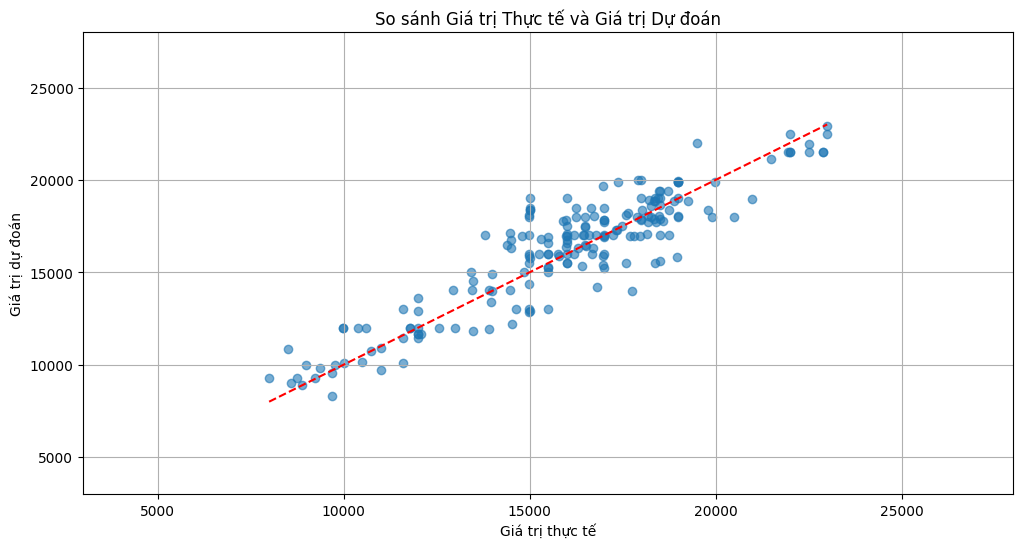

In [26]:
import matplotlib.pyplot as plt

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Đường chuẩn
plt.title('So sánh Giá trị Thực tế và Giá trị Dự đoán')
plt.xlabel('Giá trị thực tế')
plt.ylabel('Giá trị dự đoán')
plt.grid()
plt.xlim(y_test.min() - 5000, y_test.max() + 5000)  # Điều chỉnh giới hạn trục x
plt.ylim(y_test.min() - 5000, y_test.max() + 5000)  # Điều chỉnh giới hạn trục y
plt.show()